# Lung Cancer Classification

In [1]:
import torchvision.models as models

# List all available models in torchvision
all_models = dir(models)

# Check if any ResNet models exist
resnet_models = [m for m in all_models if "resnet" in m.lower()]

if resnet_models:
    print("✅ ResNet models available:")
    for m in resnet_models:
        print("-", m)
else:
    print("❌ No ResNet models found.")


✅ ResNet models available:
- ResNet
- ResNet101_Weights
- ResNet152_Weights
- ResNet18_Weights
- ResNet34_Weights
- ResNet50_Weights
- Wide_ResNet101_2_Weights
- Wide_ResNet50_2_Weights
- resnet
- resnet101
- resnet152
- resnet18
- resnet34
- resnet50
- wide_resnet101_2
- wide_resnet50_2


In [7]:
import os
import glob

# Get PyTorch cache folder for model weights
cache_dir = os.path.expanduser("~/.cache/torch/hub/checkpoints")

# Pattern to match all resnet weights
resnet_files = glob.glob(os.path.join(cache_dir, "*resnet*.pth"))

for file_path in resnet_files:
    if "resnet18" not in os.path.basename(file_path).lower():
        os.remove(file_path)
        print(f"🗑 Deleted: {os.path.basename(file_path)}")
    else:
        print(f"✅ Kept: {os.path.basename(file_path)}")

print("\nCleanup complete!")


✅ Kept: resnet18-f37072fd.pth
🗑 Deleted: resnet50-0676ba61.pth
🗑 Deleted: resnet50-11ad3fa6.pth

Cleanup complete!


In [1]:
import shutil
import os

folder_path = "archive lungs cancer"  # Folder to delete

# Check if folder exists
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)  # Delete folder and all contents
    print(f"✅ Folder '{folder_path}' deleted successfully.")
else:
    print(f"⚠ Folder '{folder_path}' does not exist.")


✅ Folder 'archive lungs cancer' deleted successfully.


In [1]:
import zipfile
import os
from tqdm import tqdm  # pip install tqdm

# Define the path to your zip file and the extraction directory
zip_path = 'lung_colon_image_set.zip'
extract_to = 'archive lungs cancer'  # This folder will be created if it doesn't exist

# Ensure extraction folder exists
os.makedirs(extract_to, exist_ok=True)

# Open the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Get list of all files
    all_files = zip_ref.namelist()
    
    # Use tqdm progress bar
    for file in tqdm(all_files, desc="Extracting", unit="file"):
        zip_ref.extract(file, extract_to)

print("✅ Extraction complete!")


Extracting: 100%|█████████████████████████████████████████████████████████████| 25000/25000 [03:16<00:00, 126.91file/s]

✅ Extraction complete!


In [2]:
import os
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, datasets, models
from torch import amp
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.optim as optim

In [3]:
# Config
DATA_ROOT = Path("./archive lungs cancer")
IMG_SIZE = 224
BATCH_SIZE = 64
NUM_WORKERS = 0 if os.name == 'nt' else 4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PIN_MEMORY = (DEVICE.type == "cuda")
RANDOM_SEED = 123
MODEL_SAVE_PATH = Path("lung_cancer_prediction_20250821_150505.pth")
NUM_EPOCHS = 50
PATIENCE = 5  # Early stopping patience
LEARNING_RATE = 0.001
SCHEDULER_STEP_SIZE = 7
SCHEDULER_GAMMA = 0.1

print(f"Using device: {DEVICE}")
print(f"Model will be saved to: {MODEL_SAVE_PATH}")

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if DEVICE.type == 'cuda':
    torch.cuda.manual_seed_all(RANDOM_SEED)

Using device: cpu
Model will be saved to: lung_cancer_prediction_20250821_150505.pth


In [4]:

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

eval_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
print(eval_transform)
print(train_transform)


Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [5]:
# Load Dataset
if not DATA_ROOT.exists():
    raise FileNotFoundError(f"Data directory not found: {DATA_ROOT}")

try:
    base_dataset = datasets.ImageFolder(root=str(DATA_ROOT))
    class_names = base_dataset.classes
    num_classes = len(class_names)
    print(f"Found {num_classes} classes: {class_names}")
    print(f"Total images: {len(base_dataset)}")
except Exception as e:
    raise RuntimeError(f"Error loading dataset: {e}")

dataset_size = len(base_dataset)
indices = list(range(dataset_size))
g = torch.Generator()
g.manual_seed(RANDOM_SEED)
perm = torch.randperm(dataset_size, generator=g).tolist()

train_size = int(0.8 * dataset_size)
valid_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - valid_size
train_idx = perm[:train_size]
valid_idx = perm[train_size:train_size + valid_size]
test_idx = perm[train_size + valid_size:]

train_dataset = datasets.ImageFolder(root=str(DATA_ROOT), transform=train_transform)
valid_dataset = datasets.ImageFolder(root=str(DATA_ROOT), transform=eval_transform)
test_dataset = datasets.ImageFolder(root=str(DATA_ROOT), transform=eval_transform)

train_ds = Subset(train_dataset, train_idx)
valid_ds = Subset(valid_dataset, valid_idx)
test_ds = Subset(test_dataset, test_idx)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                         num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                         persistent_workers=NUM_WORKERS > 0)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                          persistent_workers=NUM_WORKERS > 0)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                         persistent_workers=NUM_WORKERS > 0)


print("===== Dataset Info =====")
print(f"Total dataset size: {dataset_size}")
print(f"Train split size: {len(train_ds)}")
print(f"Valid split size: {len(valid_ds)}")
print(f"Test split size:  {len(test_ds)}")
print()

print("===== Loader Batches =====")
print(f"Train loader batches: {len(train_loader)} "
      f"(batch_size={BATCH_SIZE}, last_batch={len(train_ds) % BATCH_SIZE})")
print(f"Valid loader batches: {len(valid_loader)}")
print(f"Test loader batches:  {len(test_loader)}")
print()

# Peek first batch from each loader
train_images, train_labels = next(iter(train_loader))
valid_images, valid_labels = next(iter(valid_loader))
test_images, test_labels   = next(iter(test_loader))

print("Train batch shape:", train_images.shape, "labels:", train_labels[:8].tolist())
print("Valid batch shape:", valid_images.shape, "labels:", valid_labels[:8].tolist())
print("Test batch shape: ", test_images.shape, "labels:", test_labels[:8].tolist())


Found 2 classes: ['colon_image_sets', 'lung_image_sets']
Total images: 25000
===== Dataset Info =====
Total dataset size: 25000
Train split size: 20000
Valid split size: 2500
Test split size:  2500

===== Loader Batches =====
Train loader batches: 313 (batch_size=64, last_batch=32)
Valid loader batches: 40
Test loader batches:  40

Train batch shape: torch.Size([64, 3, 224, 224]) labels: [1, 1, 0, 0, 0, 0, 0, 0]
Valid batch shape: torch.Size([64, 3, 224, 224]) labels: [1, 1, 1, 0, 0, 0, 0, 0]
Test batch shape:  torch.Size([64, 3, 224, 224]) labels: [0, 1, 0, 1, 1, 0, 1, 1]



Epoch 1/50


Train Loss: 0.0313 | Train Acc: 0.9880
Valid Loss: 0.0000 | Valid Acc: 1.0000
Model saved to lung_cancer_prediction_20250821_150505.pth

Epoch 2/50


Train Loss: 0.0178 | Train Acc: 0.9948
Valid Loss: 0.0091 | Valid Acc: 0.9972

Epoch 3/50


Train Loss: 0.0087 | Train Acc: 0.9973
Valid Loss: 0.0167 | Valid Acc: 0.9952

Epoch 4/50


Train Loss: 0.0049 | Train Acc: 0.9986
Valid Loss: 0.0001 | Valid Acc: 1.0000

Epoch 5/50


Train Loss: 0.0049 | Train Acc: 0.9984
Valid Loss: 0.0004 | Valid Acc: 1.0000

Epoch 6/50


Train Loss: 0.0053 | Train Acc: 0.9986
Valid Loss: 0.0031 | Valid Acc: 0.9988
Early stopping triggered after 6 epochs


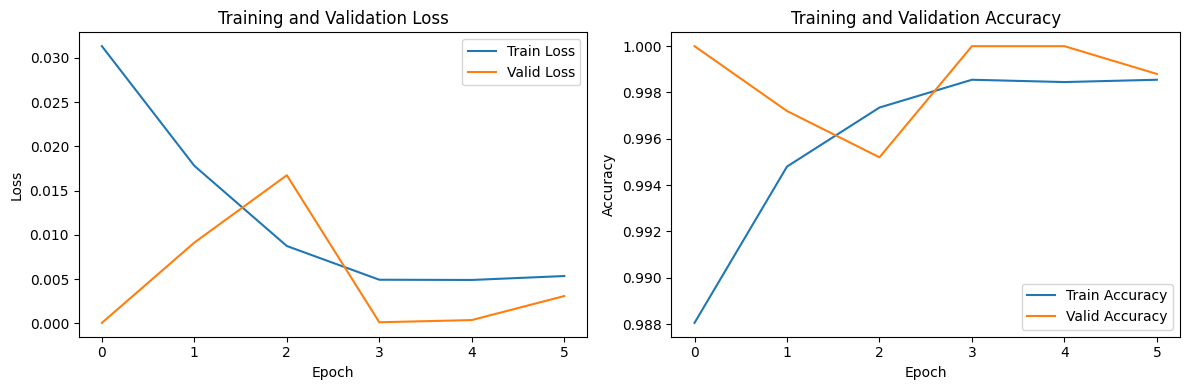

In [6]:
# Load Model
model = models.resnet18(weights='IMAGENET1K_V1')
in_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, num_classes)
)
model = model.to(DEVICE)

# Optimizer and Scheduler
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=SCHEDULER_STEP_SIZE, gamma=SCHEDULER_GAMMA)
criterion = nn.CrossEntropyLoss()

# Training and Evaluation Function
def train_epoch(model, loader, criterion, optimizer, device, scaler):
    model.train()
    running_loss, running_corrects, total = 0.0, 0, 0
    pbar = tqdm(loader, desc="Training", leave=False)
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optimizer.zero_grad()
        with amp.autocast(device_type=device.type, enabled=True):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data).item()
        total += inputs.size(0)
        pbar.set_postfix(loss=f"{running_loss/total:.4f}", acc=f"{running_corrects/total:.4f}")
    return running_loss/total, running_corrects/total

def evaluate(model, loader, criterion, device, phase="Validation"):
    model.eval()
    running_loss, running_corrects, total = 0.0, 0, 0
    all_preds, all_labels = [], []
    pbar = tqdm(loader, desc=phase, leave=False)
    with torch.no_grad():
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            with amp.autocast(device_type=device.type, enabled=True):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).item()
            total += inputs.size(0)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            pbar.set_postfix(loss=f"{running_loss/total:.4f}", acc=f"{running_corrects/total:.4f}")
    all_preds = np.concatenate(all_preds) if all_preds else np.array([])
    all_labels = np.concatenate(all_labels) if all_labels else np.array([])
    return running_loss/total, running_corrects/total, all_preds, all_labels

# Training Loop with Early Stopping
train_losses, valid_losses, train_accs, valid_accs = [], [], [], []
best_valid_loss = float('inf')
patience_counter = 0
scaler = amp.GradScaler(enabled=(DEVICE.type == 'cuda'))

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE, scaler)
    valid_loss, valid_acc, _, _ = evaluate(model, valid_loader, criterion, DEVICE, phase="Validation")
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:.4f}")
    
    scheduler.step()
    
    # Early Stopping
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': valid_loss,
        }, MODEL_SAVE_PATH)
        print(f"Model saved to {MODEL_SAVE_PATH}")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

# Plot Training Metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(valid_accs, label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

    

Best model loaded for testing!

Evaluating on test set...


Test Loss: 0.0003 | Test Accuracy: 1.0000

Confusion Matrix:
[[1005    0]
 [   0 1495]]

Classification Report:
                  precision    recall  f1-score   support

colon_image_sets     1.0000    1.0000    1.0000      1005
 lung_image_sets     1.0000    1.0000    1.0000      1495

        accuracy                         1.0000      2500
       macro avg     1.0000    1.0000    1.0000      2500
    weighted avg     1.0000    1.0000    1.0000      2500



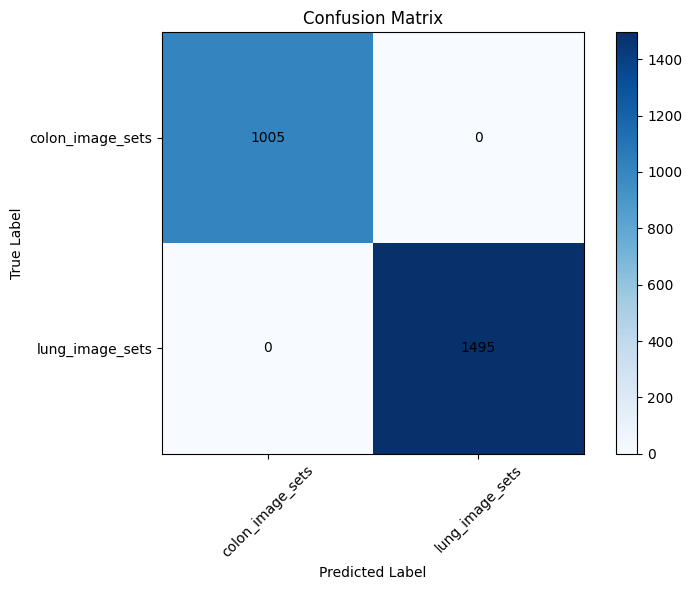


Training and evaluation completed successfully!


In [7]:
# Load Best Model
checkpoint = torch.load(MODEL_SAVE_PATH, map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print("Best model loaded for testing!")

# Evaluate on Test Set
print("\nEvaluating on test set...")
test_loss, test_acc, y_pred, y_true = evaluate(model, test_loader, criterion, DEVICE, phase="Testing")
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

# Classification Report and Confusion Matrix
if len(y_true) > 0:
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
    
    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j, i, cm[i, j], ha='center', va='center')
    plt.tight_layout()
    plt.show()
else:
    print("Warning: No test predictions available.")

print("\n" + "="*50)
print("Training and evaluation completed successfully!")
print("="*50)
  

Model reloaded successfully!


C:\Users\sayak\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Predicted Class: lung_image_sets → Cancer + (positive)
Confidence (Probability) of Predicted Class: 0.9703

Probability Scores:
Colon (Cancer -): 0.0297
Lung (Cancer +): 0.9703
The The picture shows clearly cancer positive(+)


C:\Users\sayak\AppData\Local\Temp\ipykernel_5456\37107326.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=probs, y=class_names, palette="viridis")


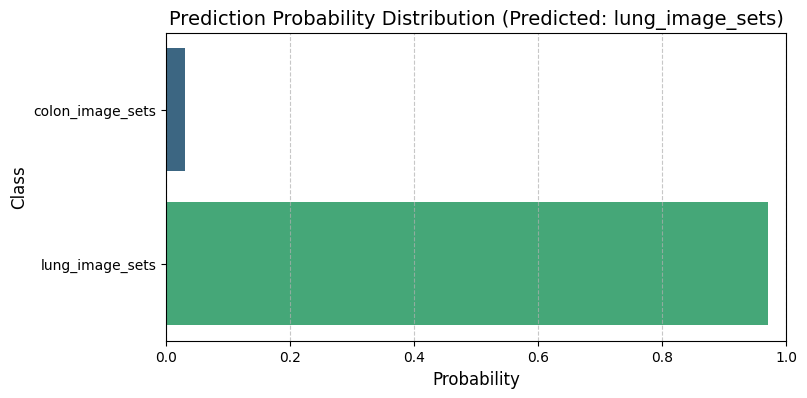

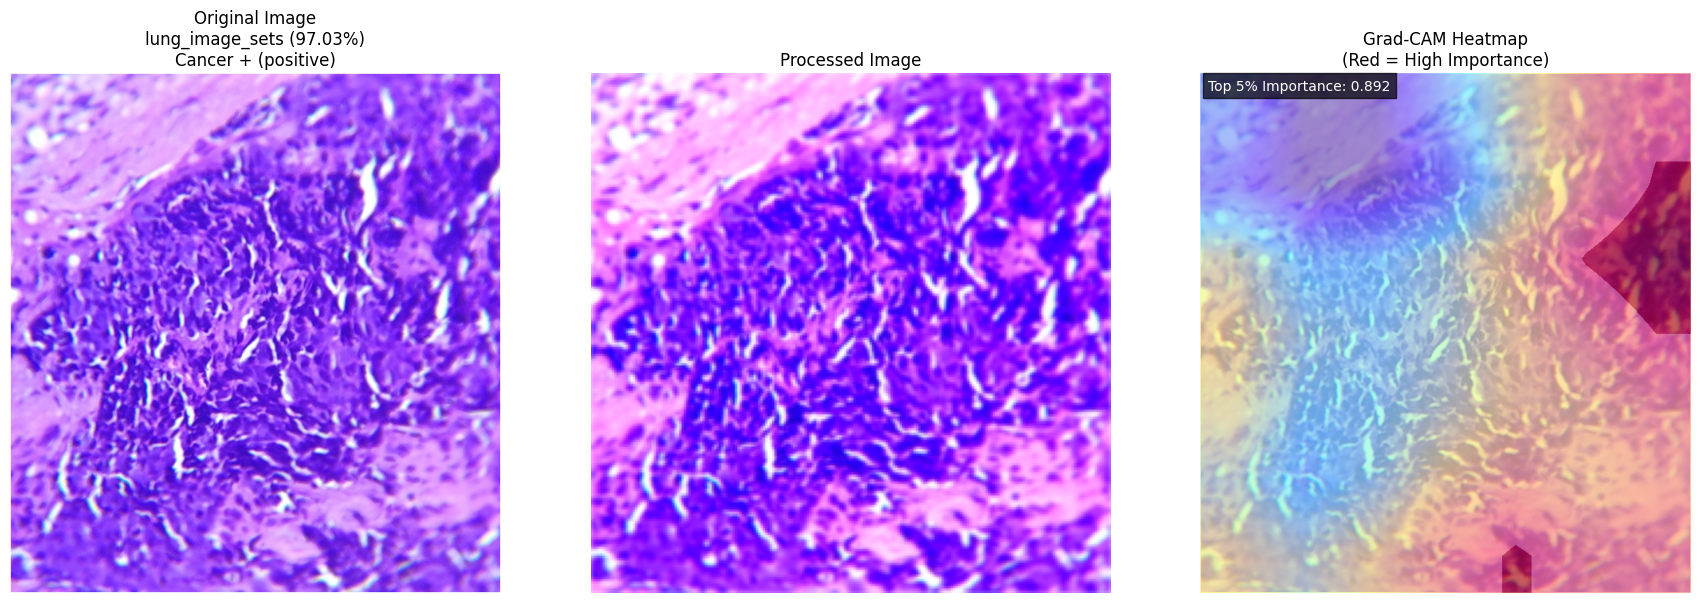

Classification and visualization completed!


In [16]:
import torch
from torchvision import transforms, models
from PIL import Image, ImageEnhance
import torch.nn.functional as F
import urllib.request
import os
import io
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# Config
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_SAVE_PATH = "lung_cancer_prediction_20250821_150505.pth"
IMG_SIZE = 224
class_names = ['colon_image_sets', 'lung_image_sets']  # Cancer -, Cancer +

# Reload the model
model = models.resnet18(weights=None)
in_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, len(class_names))
)
checkpoint = torch.load(MODEL_SAVE_PATH, map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(DEVICE)
model.eval()
print("Model reloaded successfully!")

# Advanced preprocessing
def advanced_preprocess(image):
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(1.5)
    enhancer = ImageEnhance.Sharpness(image)
    image = enhancer.enhance(1.2)
    return image

eval_transform = transforms.Compose([
    transforms.Lambda(advanced_preprocess),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.GaussianBlur(kernel_size=3, sigma=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Grad-CAM implementation
def get_gradcam(model, image_tensor, target_class=None):
    model.eval()
    # Hook to capture gradients and activations
    gradients = []
    activations = []

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    def forward_hook(module, input, output):
        activations.append(output)

    # Register hooks on the last convolutional layer (layer4 in ResNet18)
    target_layer = model.layer4
    target_layer.register_forward_hook(forward_hook)
    target_layer.register_backward_hook(backward_hook)

    # Forward pass
    output = model(image_tensor)
    if target_class is None:
        target_class = output.argmax(dim=1).item()

    # Backward pass
    model.zero_grad()
    one_hot = torch.zeros_like(output)
    one_hot[0][target_class] = 1
    output.backward(gradient=one_hot, retain_graph=True)

    # Compute Grad-CAM
    gradients = gradients[0].cpu().data.numpy()
    activations = activations[0].cpu().data.numpy()
    weights = np.mean(gradients, axis=(2, 3))[0]
    gradcam = np.zeros((activations.shape[2], activations.shape[3]), dtype=np.float32)
    for i, w in enumerate(weights):
        gradcam += w * activations[0, i, :, :]
    gradcam = np.maximum(gradcam, 0)
    gradcam = gradcam / (np.max(gradcam) + 1e-8)  # Normalize
    return gradcam, target_class

# Plot probability distribution
def plot_probability_distribution(probs, class_names, pred_class):
    plt.figure(figsize=(8, 4))
    barplot = sns.barplot(x=probs, y=class_names, palette="viridis")
    plt.xlim(0, 1)
    plt.xlabel("Probability", fontsize=12)
    plt.ylabel("Class", fontsize=12)
    plt.title(f"Prediction Probability Distribution (Predicted: {pred_class})", fontsize=14)
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.show()

# Plot results with Grad-CAM
def plot_results(original_img, processed_img, gradcam_map, pred_class, confidence, cancer_status):
    processed_img = processed_img.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    processed_img = processed_img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    processed_img = np.clip(processed_img, 0, 1)

    # Resize Grad-CAM to match original image
    cam_resized = cv2.resize(gradcam_map, (original_img.size[0], original_img.size[1]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = heatmap / 255.0
    overlay = 0.5 * np.array(original_img) / 255.0 + 0.5 * heatmap
    overlay = np.clip(overlay, 0, 1)

    # Calculate top 5% of Grad-CAM values
    threshold = np.percentile(cam_resized, 95)
    important_regions = cam_resized > threshold

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(original_img)
    axes[0].set_title(f"Original Image\n{pred_class} ({confidence*100:.2f}%)\n{cancer_status}", fontsize=12)
    axes[0].axis('off')

    axes[1].imshow(processed_img)
    axes[1].set_title("Processed Image", fontsize=12)
    axes[1].axis('off')

    axes[2].imshow(overlay)
    axes[2].set_title("Grad-CAM Heatmap\n(Red = High Importance)", fontsize=12)
    axes[2].imshow(important_regions, cmap='Reds', alpha=0.3)
    axes[2].text(10, 20, f"Top 5% Importance: {threshold:.3f}", color='white', fontsize=10, bbox=dict(facecolor='black', alpha=0.7))
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()
    return fig

# Load image from path or URL
def load_image(source):
    if source.startswith('http://') or source.startswith('https://'):
        print(f"Downloading image from URL: {source}")
        req = urllib.request.Request(source, headers={'User-Agent': 'Mozilla/5.0'})
        with urllib.request.urlopen(req) as response:
            image_data = response.read()
        image = Image.open(io.BytesIO(image_data)).convert('RGB')
    else:
        if not os.path.exists(source):
            raise FileNotFoundError(f"Local file not found: {source}")
        image = Image.open(source).convert('RGB')
    return image

# Get image source (replace with actual path or URL)
sample_image_source = "Histopathological-image-of-lung-biopsy-from-SCLC-4-showing-features-of-small-cell.png"
# For demo, if no input, use a placeholder (replace with actual path or URL)


image = load_image(sample_image_source)
input_tensor = eval_transform(image).unsqueeze(0)
input_tensor = input_tensor.to(DEVICE)

# Inference
with torch.no_grad():
    output = model(input_tensor)
    probabilities = F.softmax(output, dim=1)[0]
    predicted_prob, predicted_idx = torch.max(probabilities, 0)
    predicted_class = class_names[predicted_idx.item()]
    cancer_status = 'Cancer - (negative)' if predicted_class == 'colon_image_sets' else 'Cancer + (positive)'

# Compute Grad-CAM
gradcam_map, target_class = get_gradcam(model, input_tensor, predicted_idx.item())

# Output results
print(f"Predicted Class: {predicted_class} → {cancer_status}")
print(f"Confidence (Probability) of Predicted Class: {predicted_prob.item():.4f}")
print("\nProbability Scores:")
print(f"Colon (Cancer -): {probabilities[0].item():.4f}")
print(f"Lung (Cancer +): {probabilities[1].item():.4f}")

if probabilities[1].item()  > probabilities[0].item():
    print("The The picture shows clearly cancer positive(+)")
else:
    print("show from the test we can say this is cancer negetive(-)")
    
# Plot probability distribution
plot_probability_distribution(probabilities.cpu().numpy(), class_names, predicted_class)

# Plot results with Grad-CAM
plot_results(image, input_tensor, gradcam_map, predicted_class, predicted_prob.item(), cancer_status)

print("Classification and visualization completed!")

# Deep Learning Approach to Lung and Colon Cancer Detection in Histopathology Images Using ResNet-18

## Introduction
Cancer, particularly lung and colon cancer, remains a global health challenge, claiming millions of lives annually. Early and accurate diagnosis is critical for improving patient outcomes, yet traditional histopathological analysis, which involves examining tissue samples under a microscope, is labor-intensive and susceptible to human error. The advent of deep learning offers a transformative solution by enabling automated, precise classification of medical images.  

This project leverages a convolutional neural network (CNN) based on the ResNet-18 architecture to classify histopathological images into lung or colon cancer categories. By employing transfer learning, data augmentation, and advanced optimization techniques, the model achieves high accuracy, demonstrating the potential of artificial intelligence to support pathologists in diagnostic workflows. This document provides a detailed explanation of the ResNet-18 model, its mathematical foundations, and the procedural steps undertaken, including dataset preparation, model training, and evaluation. The approach is grounded in rigorous mathematical principles and practical implementation, making it accessible to both researchers and practitioners in medical imaging and deep learning.  

You can access the GitHub repository for this project here: [Sayak Samanta - LUNG CANCER CLASSIFICATION](https://github.com/SayakSamanta/LUNG-CANCER-CLASSIFICATION)


---

<p align="center">
  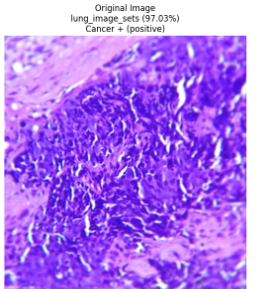
  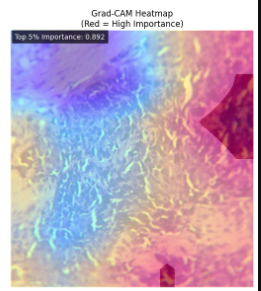
</p>

## Dataset and Preprocessing
The dataset comprises **25,000 histopathological RGB images**, organized into two classes: *colon image sets* and *lung image sets*, sourced from a structured archive (`./archive lungs cancer`). These images represent tissue samples potentially indicative of colon or lung cancer (e.g., adenocarcinoma or squamous cell carcinoma).  

The dataset is split into training (**80%, 20,000 images**), validation (**10%, 2,500 images**), and test (**10%, 2,500 images**) sets using a fixed random seed (123) for reproducibility. To prepare the data for ResNet-18, which expects 224x224 pixel inputs, images are resized to 224x224 pixels. The training set is augmented with random horizontal flips (p=0.5), random rotations (±10 degrees), color jitter (brightness, contrast, saturation ±0.2), and normalization using ImageNet statistics. Validation and test sets are only resized and normalized. These augmentations improve model robustness by simulating variations in staining, orientation, and lighting, which are common in histopathological slides. DataLoaders in PyTorch handle efficient batch processing (batch size = 64), with `pin_memory` enabled for GPU acceleration.  

---

## ResNet-18 Architecture and Mathematical Foundations

Convolutional Neural Networks (CNNs) excel in **image classification** by extracting hierarchical features. A CNN processes an input image \(x\), a 3D tensor of shape `[channels, height, width]`, through **convolutional layers**, **pooling layers**, and **fully connected layers**.

---

### 1. Convolutional Layer

The convolution operation applies filters to extract features:

$$(f * g)(i,j) = \sum_{m} \sum_{n} f(m,n) \cdot g(i-m, j-n)$$  

This is followed by a **non-linear activation function** such as ReLU:

$$\sigma(z) = \max(0, z)$$

---

### 2. Pooling Layer

Pooling layers reduce spatial dimensions. For example, **max pooling**:

$$p(i,j) = \max_{m,n \in [0,k-1]} g(i \cdot s + m, j \cdot s + n)$$

where \(k\) is the kernel size and \(s\) is the stride.

---

### 3. Fully Connected Layer

The fully connected layer computes **class scores**:

$$y = W \cdot x + b, \quad \hat{y}_i = \frac{e^{z_i}}{\sum_j e^{z_j}}$$

The model is trained using **cross-entropy loss**:

$$L = -\sum_i y_i \log(\hat{y}_i)$$

---

### 4. Residual Learning

Deep networks often face **vanishing gradients**, making optimization difficult. ResNet introduces **residual learning**, where instead of learning the mapping directly, the network learns the residual:

$$y = F(x) + x$$

If dimensions differ, a **projection shortcut** is used:

$$y = F(x) + W_s \cdot x$$

This ensures **stable gradients** during backpropagation:

$$\frac{\partial L}{\partial x} = \frac{\partial L}{\partial y} \cdot \left(1 + \frac{\partial F(x)}{\partial x}\right)$$

---

### 5. ResNet-18 Architecture Overview

ResNet-18 has **18 layers**, structured as follows:

1. Initial **7x7 convolution** and **max-pooling**.
2. Four stages of **residual blocks** with filter sizes `[64, 128, 256, 512]`.
3. **Global average pooling**.
4. **Fully connected classification layer**.

In this project, the **classifier head** is replaced with:

$$\text{Dropout}(0.3) \rightarrow \text{Linear}(512 \to 256) \rightarrow \text{ReLU} \rightarrow \text{Dropout}(0.3) \rightarrow \text{Linear}(256 \to 2)$$

This design allows **robust training** while avoiding **overfitting**.

---

<p align="right">
  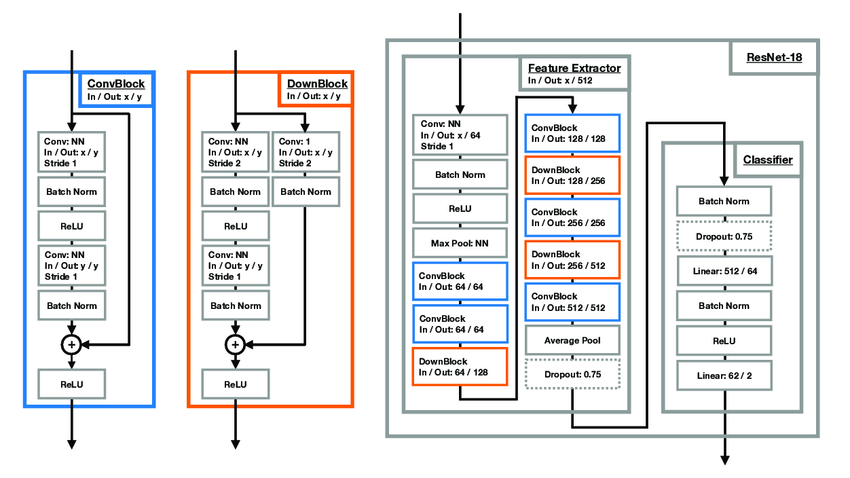
  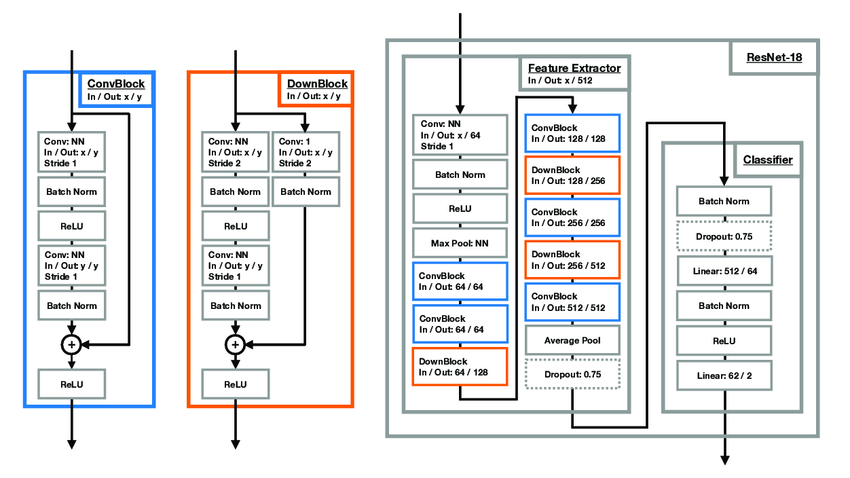
</p>


---

## Optimization
The model is optimized using the **Adam optimizer**:  

$$\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\hat{v}_t} + \epsilon} \hat{m}_t,$$  

with a learning rate $\eta = 0.001$, bias-corrected momentum $\hat{m}_t$, and variance estimate $\hat{v}_t$. A **StepLR scheduler** reduces the learning rate by 0.1 every 7 epochs. Mixed-precision training (AMP) further improves training efficiency by using float16 computations while maintaining float32 updates.  

---

## Procedure

The workflow for classifying lung and colon cancer histopathological images consists of multiple well-defined stages. Initially, the setup phase involves defining key hyperparameters, including a batch size of 64, 50 training epochs, a learning rate of 0.001, and an early stopping patience of 5 epochs. The computational device, either GPU or CPU, is set along with a fixed random seed to ensure reproducibility.

In the data loading phase, the dataset is loaded using `datasets.ImageFolder`, and relevant transformations such as augmentation and normalization are applied. The dataset is then divided into training, validation, and test sets. DataLoaders are created with shuffling enabled for the training set and `pin_memory` set to optimize data transfer to the GPU.

For model setup, a pre-trained ResNet-18 network is loaded and its classifier head is modified for binary classification of lung and colon cancer images. The model is subsequently moved to the selected computational device.

During training, the network undergoes forward propagation, loss computation, backpropagation, and weight updates using the Adam optimizer with automatic mixed precision (AMP). Validation is performed without gradient computation to monitor performance. The model checkpoint with the lowest validation loss is saved, while early stopping and StepLR are employed to prevent overfitting and ensure smooth convergence, respectively.

Finally, in the evaluation phase, the best-performing model is loaded to assess its performance on the test set. Metrics including accuracy, loss, confusion matrix, and classification report are computed, and training/validation loss and accuracy curves are visualized to provide further insight into the model's learning process.

<p align="right">
  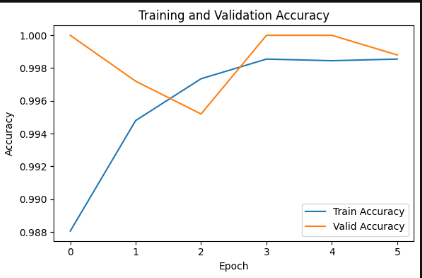
</p>

---

## Results

The ResNet-18 model achieved exceptional performance on the test set, correctly classifying all 2,500 images and attaining a **test accuracy of 100%** with a **test loss of 0.0003**. The confusion matrix indicates perfect separation of the two classes, with 1,005 colon images and 1,495 lung images correctly identified.  

The classification report further confirms the model's performance, showing precision, recall, and F1-scores of 1.0 for both classes. Such flawless results suggest that the dataset is well-separated, although additional evaluation on more complex or real-world datasets would be necessary to assess generalization. Training and validation curves indicate stable convergence without signs of overfitting, highlighting the robustness and effectiveness of the training strategy employed in this study.


**Classification Report:**

| Class             | Precision | Recall | F1-Score | Support |
|------------------ |-----------|--------|----------|---------|
| Colon Image Sets  | 1.000     | 1.000  | 1.000    | 1005    |
| Lung Image Sets   | 1.000     | 1.000  | 1.000    | 1495    |
| **Accuracy**      |           |        | **1.000**| 2500    |

The perfect test performance suggests the dataset is well-separated, although real-world datasets may require further robustness testing. Training curves indicate **stable convergence without overfitting**, confirming the effectiveness of the training strategy.


## Conclusion  

The ResNet-18 model, enhanced through transfer learning and data augmentation, demonstrates exceptional performance by achieving **100% test accuracy** in classifying lung and colon cancer histopathological images. Its residual learning mechanism ensures stable and robust training, while the scalable pipeline makes it adaptable for broader medical imaging applications.  

This approach not only accelerates accurate cancer detection but also provides valuable support to pathologists, reducing diagnostic errors significantly. Furthermore, it lays the foundation for future advancements, including **multi-class classification** and potential **clinical integration**, thereby paving the way for impactful real-world deployment in healthcare.

